In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import compute_coverage
from glob import glob
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from matplotlib.ticker import MaxNLocator

In [2]:
import sys
print(sys.version)
!conda list python

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:09:02) [GCC 11.2.0]
# packages in environment at /root/miniconda3/envs/jupyter:
#
# Name                     Version          Build               Channel
brotli-python              1.0.9            py313h6a678d5_9
ipython                    9.4.0            pypi_0              pypi
ipython-pygments-lexers    1.1.1            pypi_0              pypi
python                     3.13.5           h4612cfd_100_cp313
python-dateutil            2.9.0post0       py313h06a4308_2
python-json-logger         3.3.0            pypi_0              pypi
python-tzdata              2025.2           pyhd3eb1b0_0
python_abi                 3.13             0_cp313
types-python-dateutil      2.9.0.20250708   pypi_0              pypi


In [3]:
saved_batches = list(np.arange(0, 51, 10)) 

In [4]:
saved_batches

[np.int64(0),
 np.int64(10),
 np.int64(20),
 np.int64(30),
 np.int64(40),
 np.int64(50)]

In [5]:
confidence = 0.95
ci = norm.ppf((1-confidence)/2 + confidence)

In [6]:
def concat_df(estimate, cov_sqrt_inv, weights, saved_batches, param_truth, df, **kwargs):
    """
    estimate: (n_batches, n_params)
    """
    n_batches, n_params = estimate.shape
    error = (estimate - param_truth)
    std = compute_std(cov_sqrt_inv)
    tstat = compute_tstat(error, cov_sqrt_inv)
    tstat_param = error / std
    cov = np.asarray(np.abs(tstat) < ci, dtype=np.float64)
    cov_param = np.asarray(np.abs(tstat_param) < ci, dtype=np.float64)
    df_b = pd.DataFrame(dict(estimate=estimate.flatten(),
                                               std=std.flatten(),
                                               mse=np.square(error).flatten(),
                                               error=error.flatten(),
                                               tstat=tstat.flatten(),
                                               tstat_param=tstat_param.flatten(),
                                               cov=cov.flatten(),
                                               cov_param=cov_param.flatten(),
                                               weights=[weights] * (n_batches * n_params),
                                               batch=np.repeat(saved_batches, n_params).flatten(),
                                               params=np.tile(np.arange(n_params), n_batches).flatten()))
    for k, v in kwargs.items():
        df_b[k] = v
    new_df =  pd.concat([df, df_b], ignore_index=True)
    return new_df

In [7]:
def compute_std(mat):
    std = []
    for m in mat:
        minv = np.linalg.inv(m)
        std.append(np.sqrt(np.diag(np.matmul(minv, minv.T))))
    return np.array(std)

In [8]:
def compute_tstat(error, mat):
    tstat = [np.matmul(m, e) for m, e in zip(mat, error)]
    return np.array(tstat)

In [9]:
def get_param_df(path_name):
    estimate_df = pd.DataFrame()
    flag=True
    for path in glob(path_name):
        results = np.load(path)
        truth = results['thetas'][saved_batches]
        estimate_df = concat_df(results['naive_Theta'][saved_batches], results['naive_Cov_sqrt_inv'][saved_batches], 'naive', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
        estimate_df = concat_df(results['consistent_Theta'][saved_batches], results['consistent_Cov_sqrt_inv'][saved_batches], 'consistent', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
        estimate_df = concat_df(results['oracle_Theta'][saved_batches], results['oracle_Cov_sqrt_inv'][saved_batches], 'oracle', 
                                saved_batches, truth, estimate_df, floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
        estimate_df = concat_df(results['feasible_Theta'][saved_batches], results['feasible_Cov_sqrt_inv'][saved_batches], 'feasible', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'])
    return estimate_df




In [67]:
from matplotlib import rcParams
rcParams['text.usetex'] = False
import matplotlib as mpl
mpl.rcParams['legend.fontsize'] = 25
def plot(df, stat, baselines=None, col='params', col_wrap=5, estimator=np.mean, yname=None):
    g = sns.catplot(data=df, col_wrap=col_wrap, hue='weights', x='batch', y=stat, col=col, kind='point', estimator=estimator)
    g._legend.set_title("")
    titles = [r'$\theta^*_0$', r'$\theta^*_{1,1}$', r'$\theta^*_{1,2}$', r'$\theta^*_{2,1}$', r'$\theta^*_{2,2}$']
    for k in range(5):
        ax = g.axes.flatten()[k]
        ax.set_title(titles[k], fontsize=25)
        ax.set_ylabel(yname, fontsize=25)
        ax.set_xlabel('Batch', fontsize=25)
        ax.tick_params(axis='y', labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        if baselines is not None:
            ax.axhline(baselines[k], ls='--', c='k')
    # Customize legend
    g._legend.remove()  # Remove original legend
    
    # Draw new legend below the plot
    handles, labels = ax.get_legend_handles_labels()
    g.fig.legend(
        handles, 
        labels, 
        loc="lower center", 
        bbox_to_anchor=(0.45, -0.16),  # Adjust for spacing below
        ncol=len(labels), 
        frameon=True  # This puts a box around the legend
    )
    
    # Adjust layout to make space for the legend
    g.fig.subplots_adjust(bottom=0.2)

    
# sanity check the matrix-weighted vector: bias of moment

## 1. Without misspecification

In [ ]:
# df_lasso = get_param_df("./results/gmm_lasso*.npz")
# df_params = df_lasso.query("noise_std==2 & noise_dis=='normal'")

In [11]:
df_params = pd.read_csv('./plots/df_params.csv')

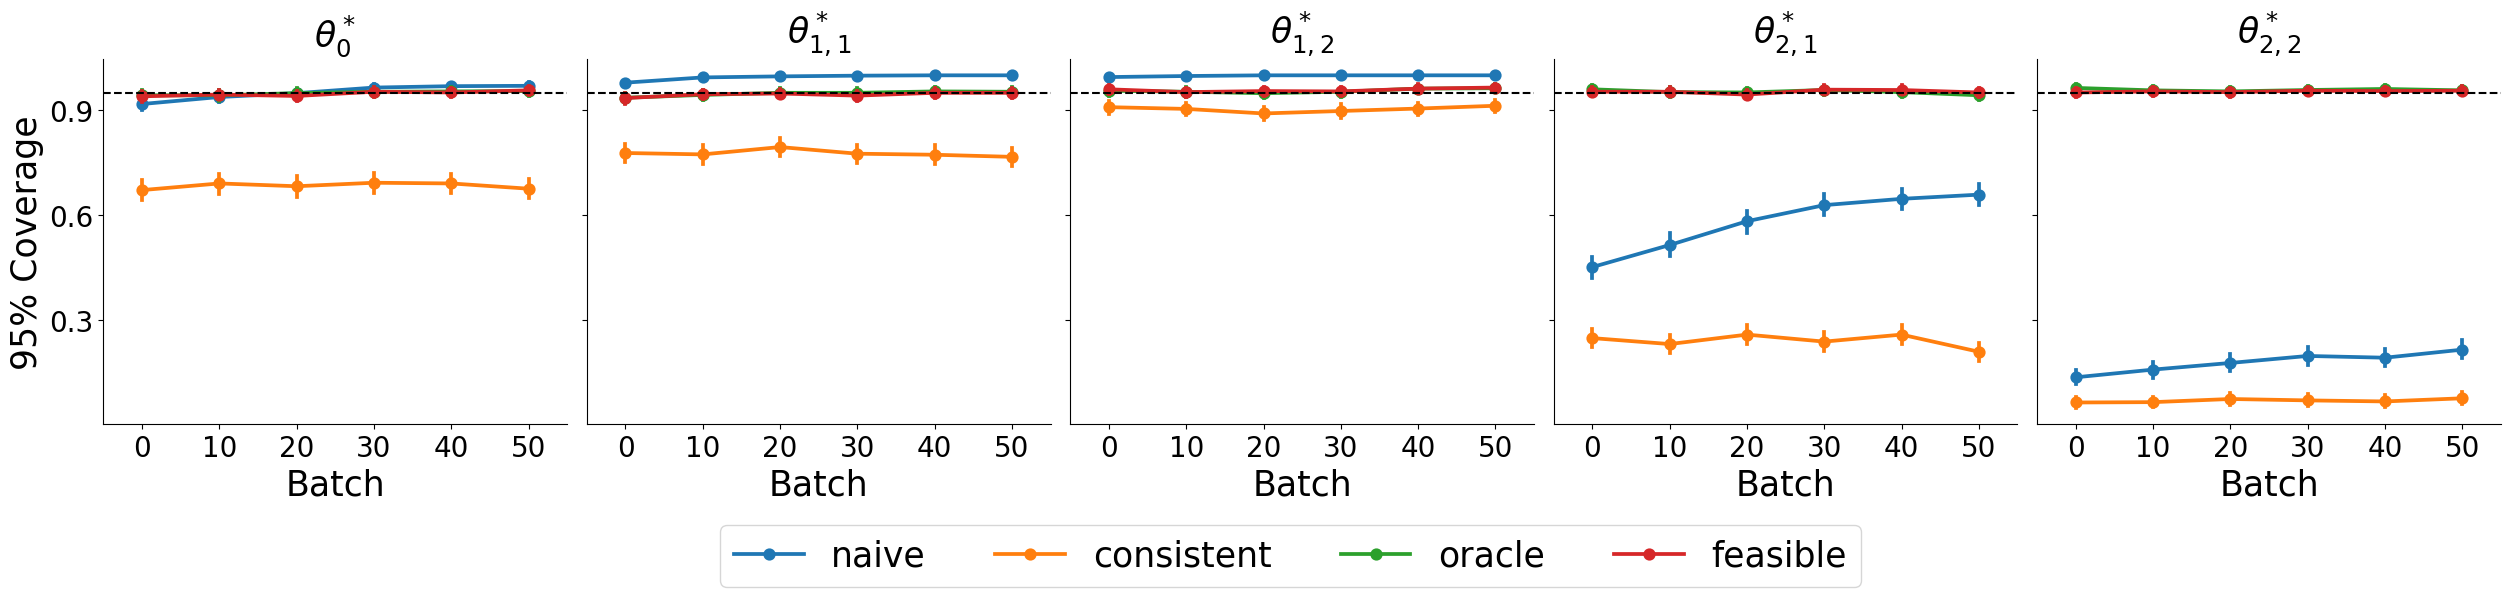

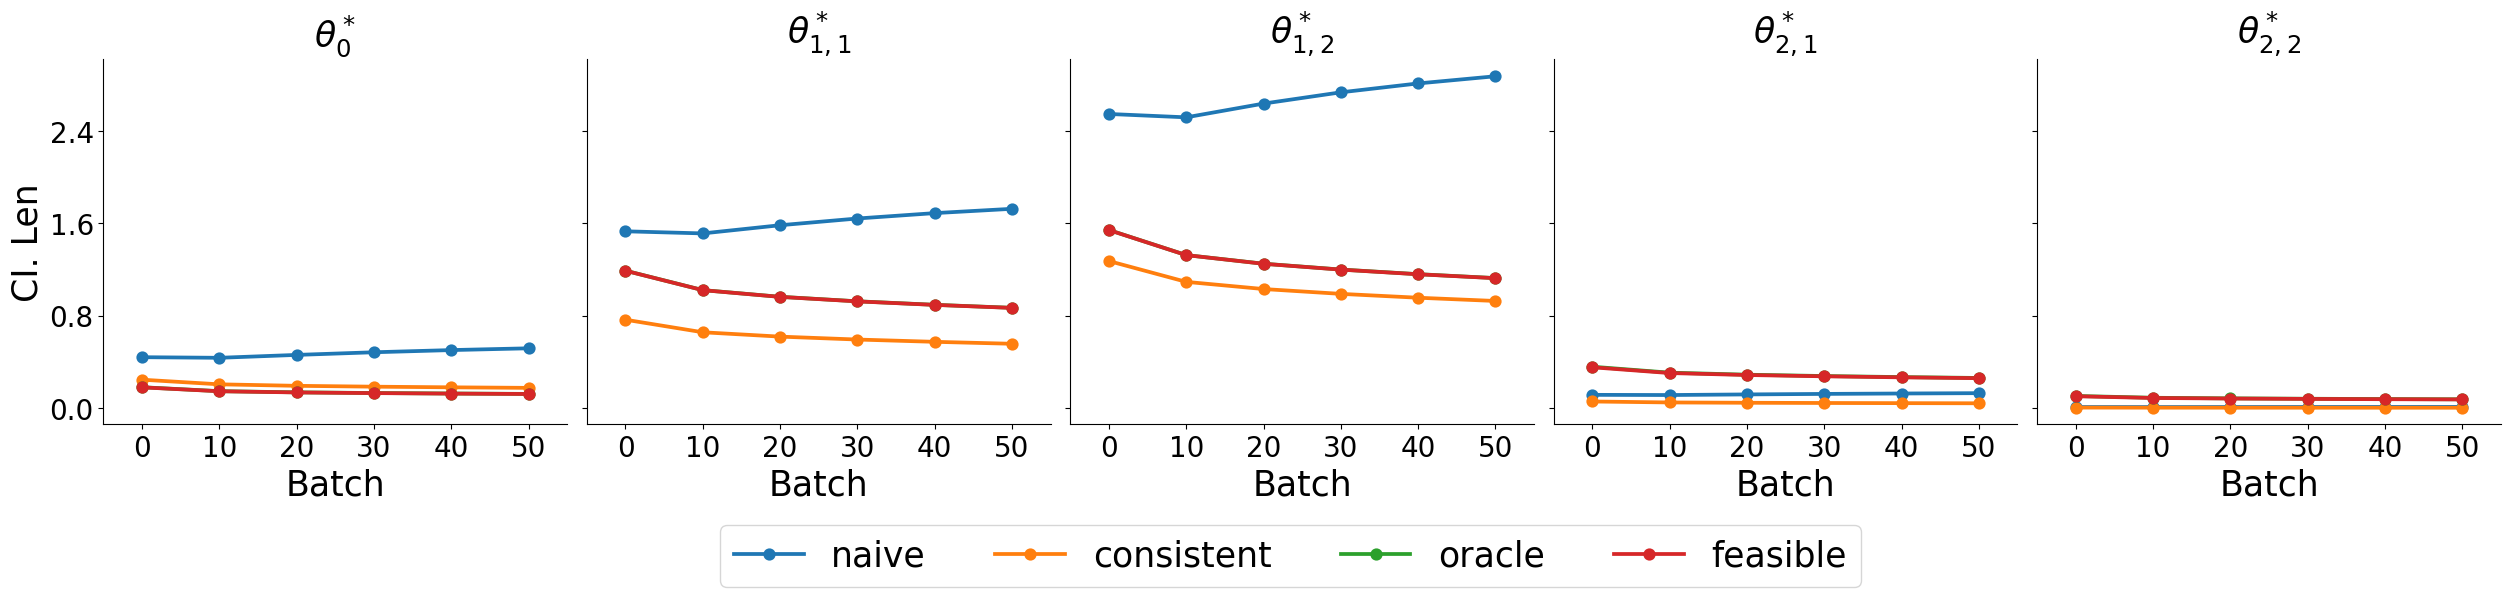

In [68]:
plot(df_params, 'cov_param', baselines=[confidence] * 5, yname=f'{int(100*confidence)}% Coverage')
plt.savefig('./plots/cov_gmm.pdf', bbox_inches='tight')
plot(df_params, 'std', estimator=lambda x:4*np.mean(x), yname='CI. Len')
plt.savefig('./plots/ci_gmm.pdf', bbox_inches='tight')

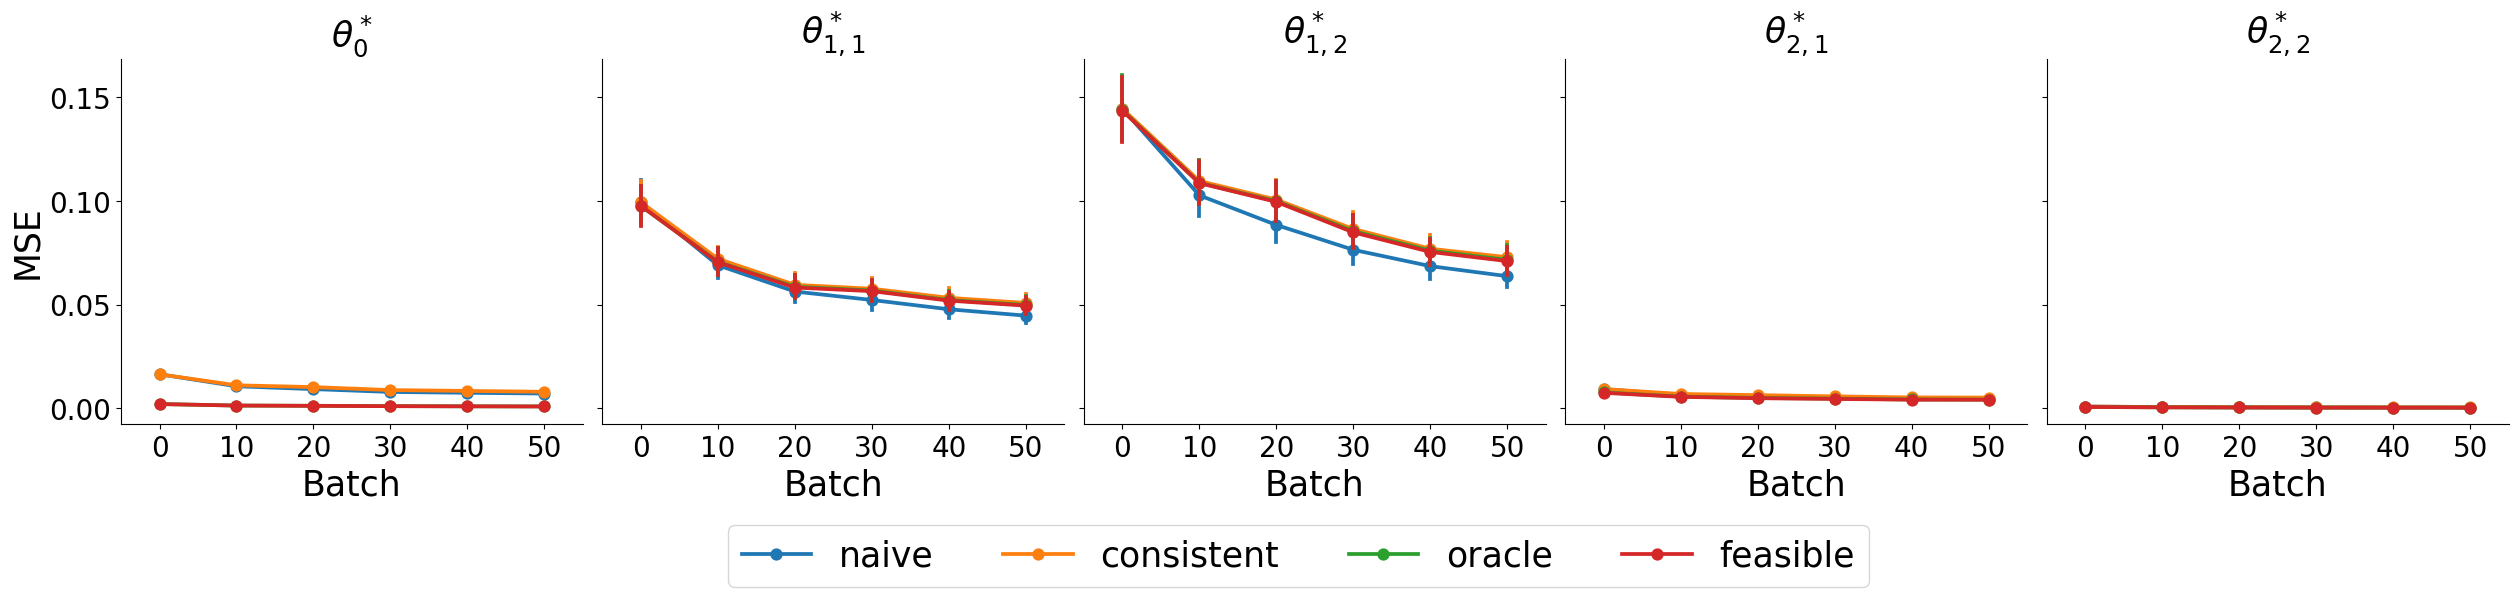

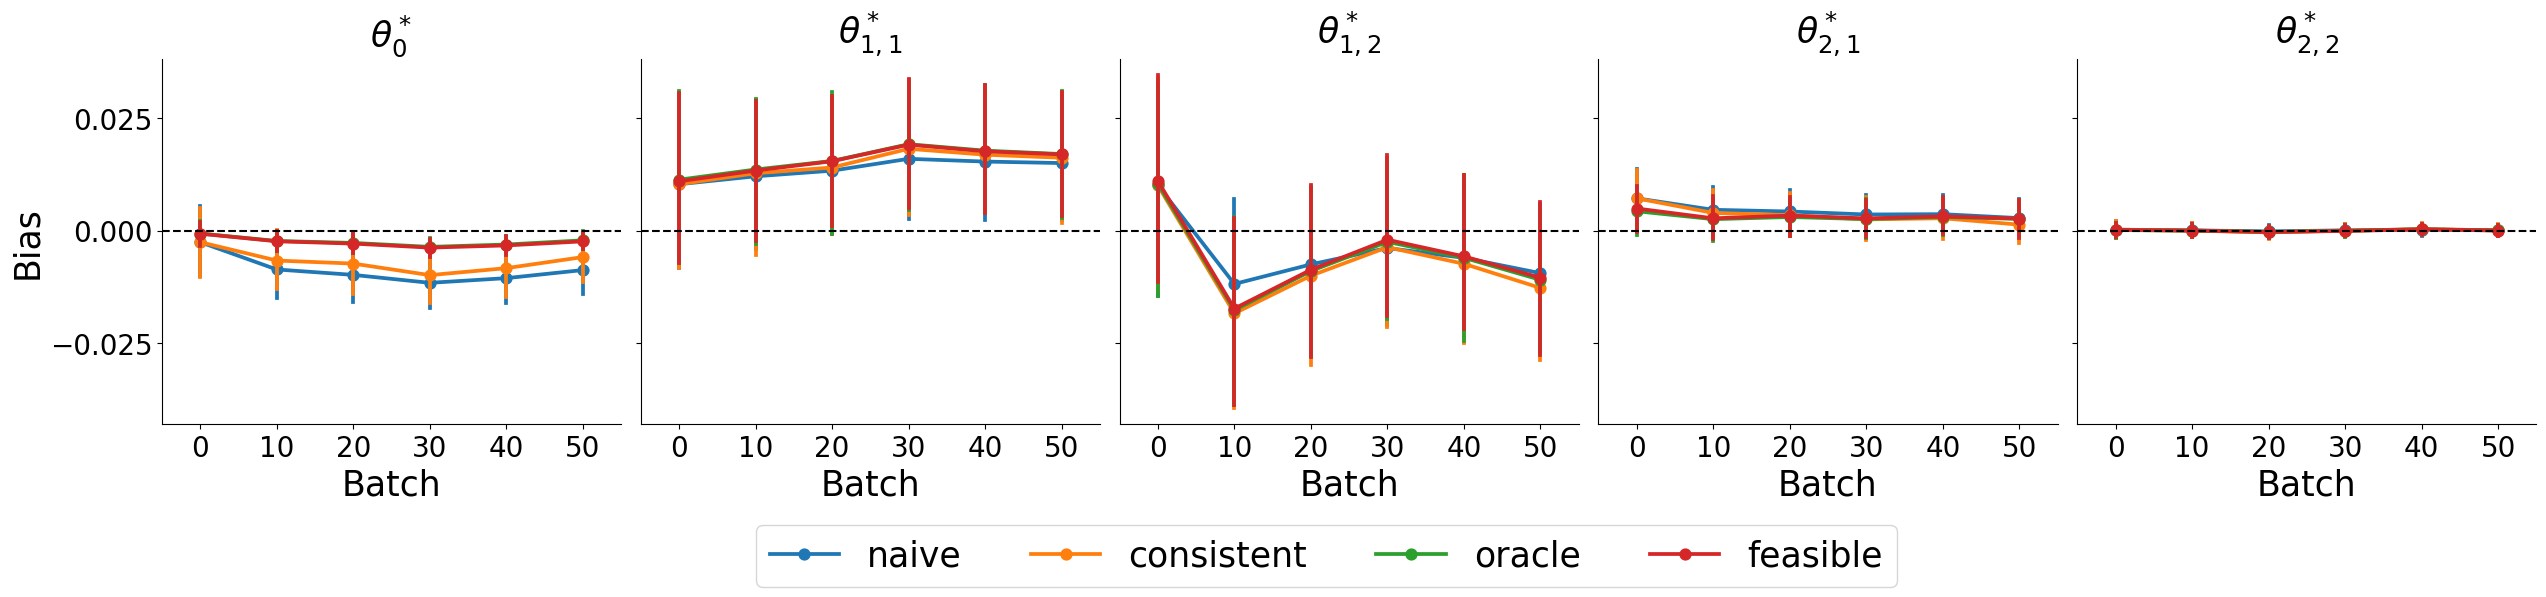

In [69]:
plot(df_params, 'mse', estimator=np.mean, yname='MSE')
plt.savefig('./plots/mse_gmm.pdf', bbox_inches='tight')
plot(df_params, 'error', baselines=[0] * 5, yname='Bias')
plt.savefig('./plots/bias_gmm.pdf', bbox_inches='tight')

In [70]:
def plot_hist(df, stat, batch=None):
    from scipy.stats import norm
    if batch is None:
        batch = np.amax(saved_batches)
    # name_dict = {0:r'$\theta_0$', 1:r'$\theta_{1,1}$', 2:r'$\theta_{1,2}$', 3:r'$\theta_{2,1}$', 4:r'$\theta_{2,2}$'}
    g = sns.FacetGrid(col="params_name",
                      row="weights",
                      sharex=True,
                      sharey=True,
                      #ylim=(0, .8),
                      xlim=(-9, 9),
                      #margin_titles=True,
                      data=df.query(f"batch=={batch}"),
                      margin_titles=True)
    g = g.map(sns.histplot, stat, kde=True, stat="density")
    g.set_titles(col_template='{col_name}', row_template="{row_name}", size=20)
    xs = np.linspace(-4, 4)
    for ax in  g.axes.flatten():
        ax.plot(xs, norm.pdf(xs),label='N(0,1)', **{"color":"black", "linestyle":"-", "linewidth":1})
        ax.set(xlabel="", ylabel="")
        ax.axvline(x=0, color="tab:orange", ls="--")
        ax.set_xticks([0])
        ax.set_yticks([0])
    handles, labels = g._legend_data.values(), g._legend_data.keys()
    g.fig.legend(labels=['Empirical density', 'Gaussian(0,1)'],  loc="lower center", ncol=2, 
                 bbox_to_anchor=(0.5, -0.07),  fontsize=20)
    g.fig.tight_layout()

In [53]:
name_dict = {0:r'$\theta^*_0$', 1:r'$\theta^*_{1,1}$', 2:r'$\theta^*_{1,2}$', 3:r'$\theta^*_{2,1}$', 4:r'$\theta^*_{2,2}$'}
df_params['params_name'] = [name_dict[i] for i in df_params.params]

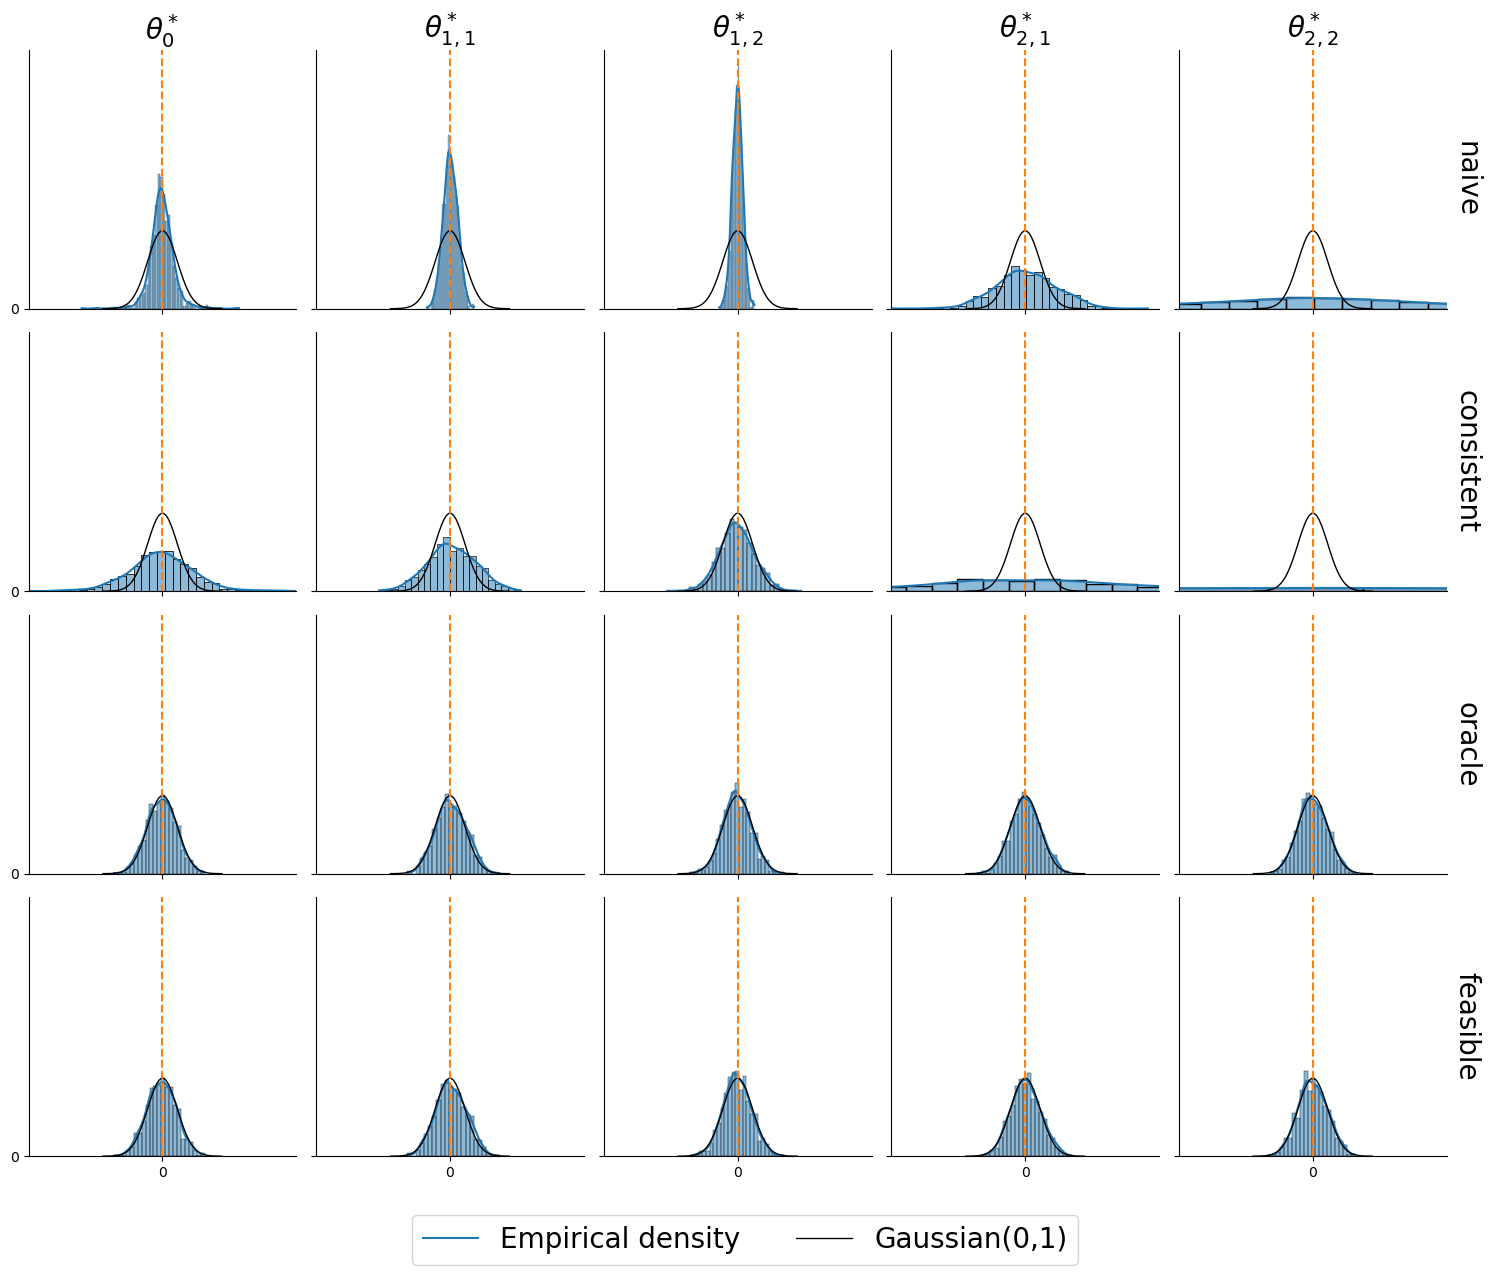

In [71]:
plot_hist(df_params, 'tstat_param')
plt.savefig('./plots/tstats_hist_gmm.pdf', bbox_inches='tight')

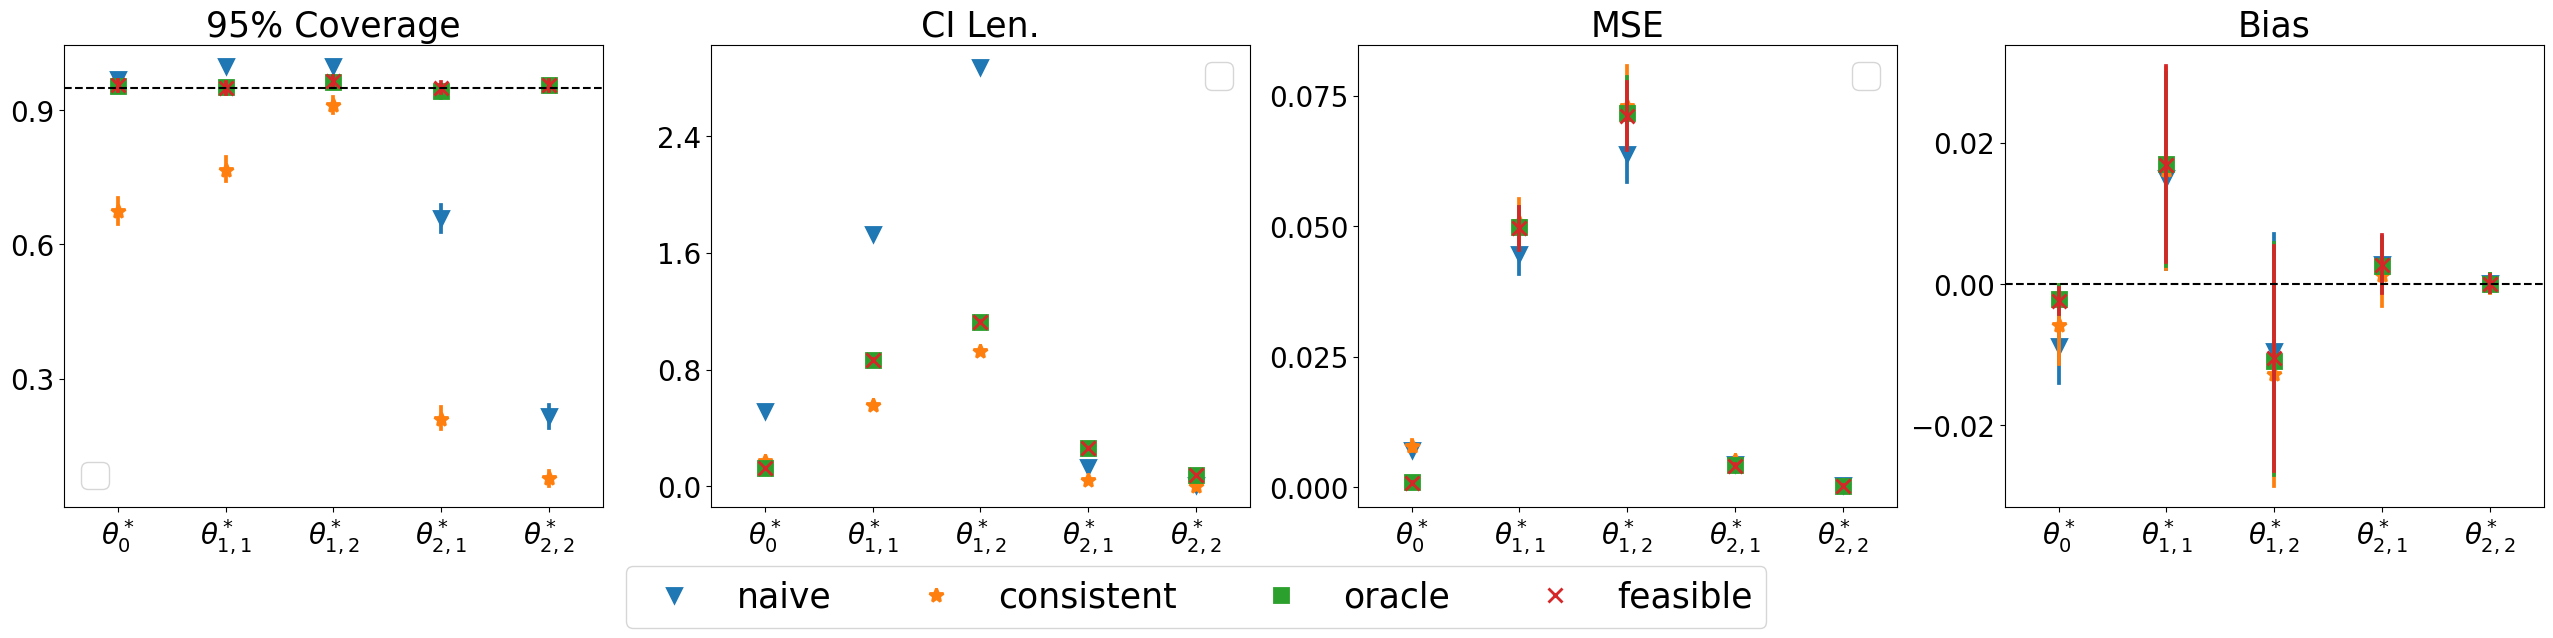

In [72]:
f, axes = plt.subplots(ncols=4, figsize=(4*8, 6))
stats = ['cov_param', 'std', 'mse', 'error']
estimators = [np.mean, lambda x:4*np.mean(x), np.mean, np.mean]
names = [f'{int(100*confidence)}% Coverage', 'CI Len.', 'MSE', 'Bias']
baselines = [confidence, None, None, 0]
x_ticklabels = [r'$\theta^*_0$', r'$\theta^*_{1,1}$', r'$\theta^*_{1,2}$', r'$\theta^*_{2,1}$', r'$\theta^*_{2,2}$']
for ax, stat, estimator, name, b in zip(axes, stats, estimators, names, baselines):
    sns.pointplot(data=df_params.query("batch==50"), x='params', y=stat, 
                  hue='weights', ax=ax, estimator=estimator, markers=["v", "*", "s", "x"], linestyle='', markersize=10)
    ax.set_title(name, fontsize=25)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(x_ticklabels, fontsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    if name == "Bias":
        ax.legend(bbox_to_anchor= (-1.5, -0.3), loc="lower center", ncols=4, fontsize=25)
    else:
        ax.legend("")
    if b is not None:
        ax.axhline(b, ls='--', c='k')
plt.savefig('./plots/lasso_last_all_gmm.pdf', bbox_inches='tight')

## 2. Comparison of different degrees of misspecification
DGP
- state covariate, scalar, $x\in R$
- treatment, binary, $t \in \{0,1\}$
- true feature mapping: $\phi(t,x)=e^{tx}-1$

$\phi(t,x)=e^{0.1*tx}-1$

$t * 1/(1+e^{-x})$

$(2 * sigmoid(x-c) - 1) * t$

We experiment different degrees of feature approximation:
- approx_degree = 1: $\Phi \sim (1, TX)$
- approx_degree = 2: $\Phi \sim (1, TX, (TX)^2)$

We compare _naive_, _consistent_, _feasible_ weighting schemes, and report estimation error and MSE of estimating baseline policy value.

In [73]:
def concat_df_misspec(estimate, cov_sqrt_inv, weights, saved_batches, param_truth, df, **kwargs):
    """
    estimate: (n_batches, n_params)
    """
    n_batches, n_params = estimate.shape
    error = (estimate[:,  0] - param_truth[:, 0])
    std = compute_std(cov_sqrt_inv)[:, 0]
    tstat_param = error / std
    cov_param = np.asarray(np.abs(tstat_param) < ci, dtype=np.float64)
    df_b = pd.DataFrame(dict(estimate=estimate[:, 0],
                             std=std.flatten(),
                             mse=np.square(error).flatten(),
                             error=error.flatten(),
                             tstat_param=tstat_param.flatten(),
                               cov_param=cov_param.flatten(),
                               weights=[weights] * (n_batches),
                               batch=saved_batches))
    for k, v in kwargs.items():
        df_b[k] = v
    new_df =  pd.concat([df, df_b], ignore_index=True)
    return new_df

def get_param_df_misspec(path_name):
    estimate_df = pd.DataFrame()
    flag=True
    for path in glob(path_name):
        results = np.load(path)
        truth = results['thetas'][saved_batches]
        estimate_df = concat_df_misspec(results['naive_Theta'][saved_batches], results['naive_Cov_sqrt_inv'][saved_batches], 'naive', 
                                saved_batches, truth, estimate_df,  scale=results['scale'],
                                        floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'], approx_degree=results['approx_degree'])
        estimate_df = concat_df_misspec(results['consistent_Theta'][saved_batches], results['consistent_Cov_sqrt_inv'][saved_batches], 'consistent', 
                                saved_batches,  truth, estimate_df,  scale=results['scale'], floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], noise_std=results['noise_std'], approx_degree=results['approx_degree'])
        estimate_df = concat_df_misspec(results['feasible_Theta'][saved_batches], results['feasible_Cov_sqrt_inv'][saved_batches], 'feasible', 
                                saved_batches, truth, estimate_df,  floor_decay=results['floor_decay'], noise_dis=results['noise_dis'], 
                                        scale=results['scale'],
                                        noise_std=results['noise_std'], approx_degree=results['approx_degree'])
    
    return estimate_df

In [165]:
df_misspec = get_param_df_misspec("./results/gmm_misspec*.npz")
df_params_misspec = df_misspec.query("noise_std==1 & noise_dis=='normal' & approx_degree < 5")

In [74]:
df_params_misspec = pd.read_csv('./plots/df_params_misspec.csv')

In [76]:
def plot_misspec(df, stat, baselines=None, col='approx_degree', col_wrap=4, estimator=np.mean, yname=None):
    g = sns.catplot(data=df, col_wrap=col_wrap, hue='weights', x='batch', y=stat, col=col, kind='point')
    g._legend.set_title("")
    titles = ['Approx.Degree = 1', 'Approx.Degree = 2', 'Approx.Degree = 3', 'Approx.Degree = 4']
    for k in range(len(titles)):
        ax = g.axes.flatten()[k]
        ax.set_title(titles[k], fontsize=25)
        ax.set_ylabel(yname, fontsize=25)
        ax.set_xlabel('Batch', fontsize=25)
        ax.tick_params(axis='y', labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        if baselines is not None:
            ax.axhline(baselines[k], ls='--', c='k')
    # Customize legend
    g._legend.remove()  # Remove original legend
    
    # Draw new legend below the plot
    handles, labels = ax.get_legend_handles_labels()
    g.fig.legend(
        handles, 
        labels, 
        loc="lower center", 
        bbox_to_anchor=(0.45, -0.16),  # Adjust for spacing below
        ncol=len(labels), 
        frameon=True  # This puts a box around the legend
    )
    
    # Adjust layout to make space for the legend
    g.fig.subplots_adjust(bottom=0.2)

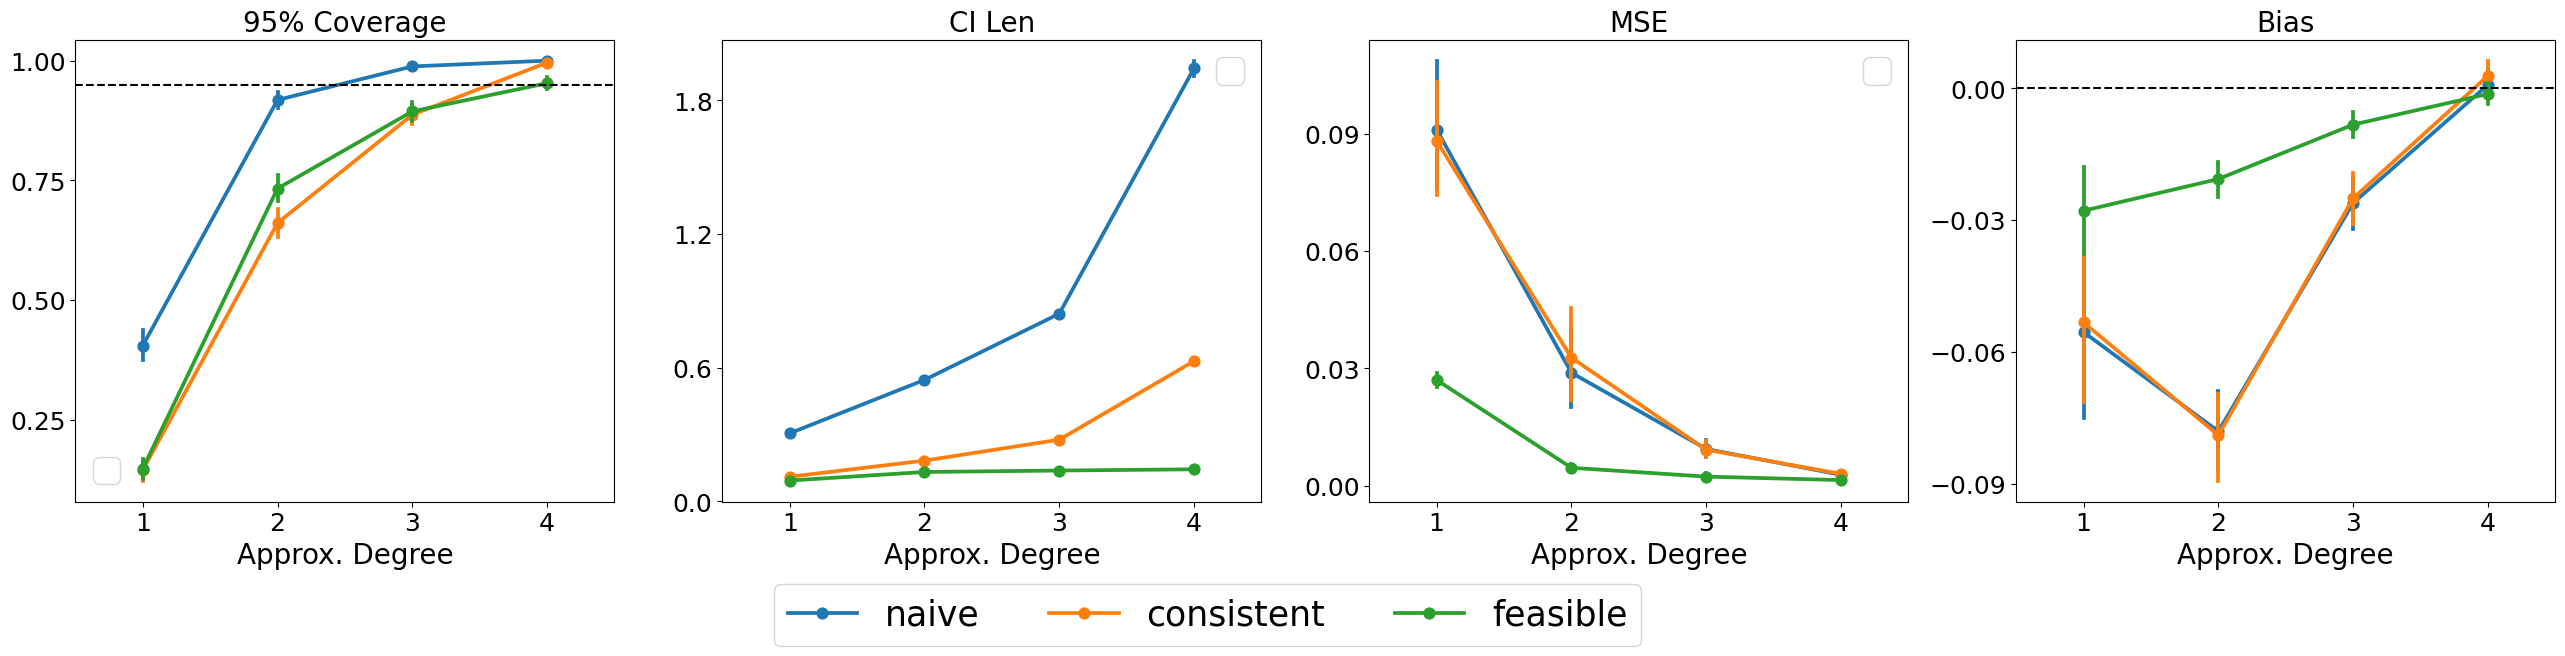

In [79]:
f, axes = plt.subplots(ncols=4, figsize=(4*8, 6))
stats = ['cov_param', 'std', 'mse', 'error']
estimators = [np.mean, lambda x:4*np.mean(x), np.mean, np.mean]
names = [f'{int(100*confidence)}% Coverage', 'CI Len', 'MSE', 'Bias']
baselines = [confidence, None, None, 0]

for ax, stat, estimator, name, b in zip(axes, stats, estimators, names, baselines):
    sns.pointplot(data=df_params_misspec.query("batch==50"), x='approx_degree', y=stat, hue='weights', ax=ax, estimator=estimator)
    ax.set_title(name, fontsize=20)
    ax.set_ylabel("")
    ax.set_xlabel('Approx. Degree', fontsize=20)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    if name == "Bias":
        ax.legend(bbox_to_anchor= (-1.5, -0.35), loc="lower center", ncols=4, fontsize=25)
    else:
        ax.legend("")
    if b is not None:
        ax.axhline(b, ls='--', c='k')
plt.savefig('./plots/misspec_last_all_gmm.pdf', bbox_inches='tight')

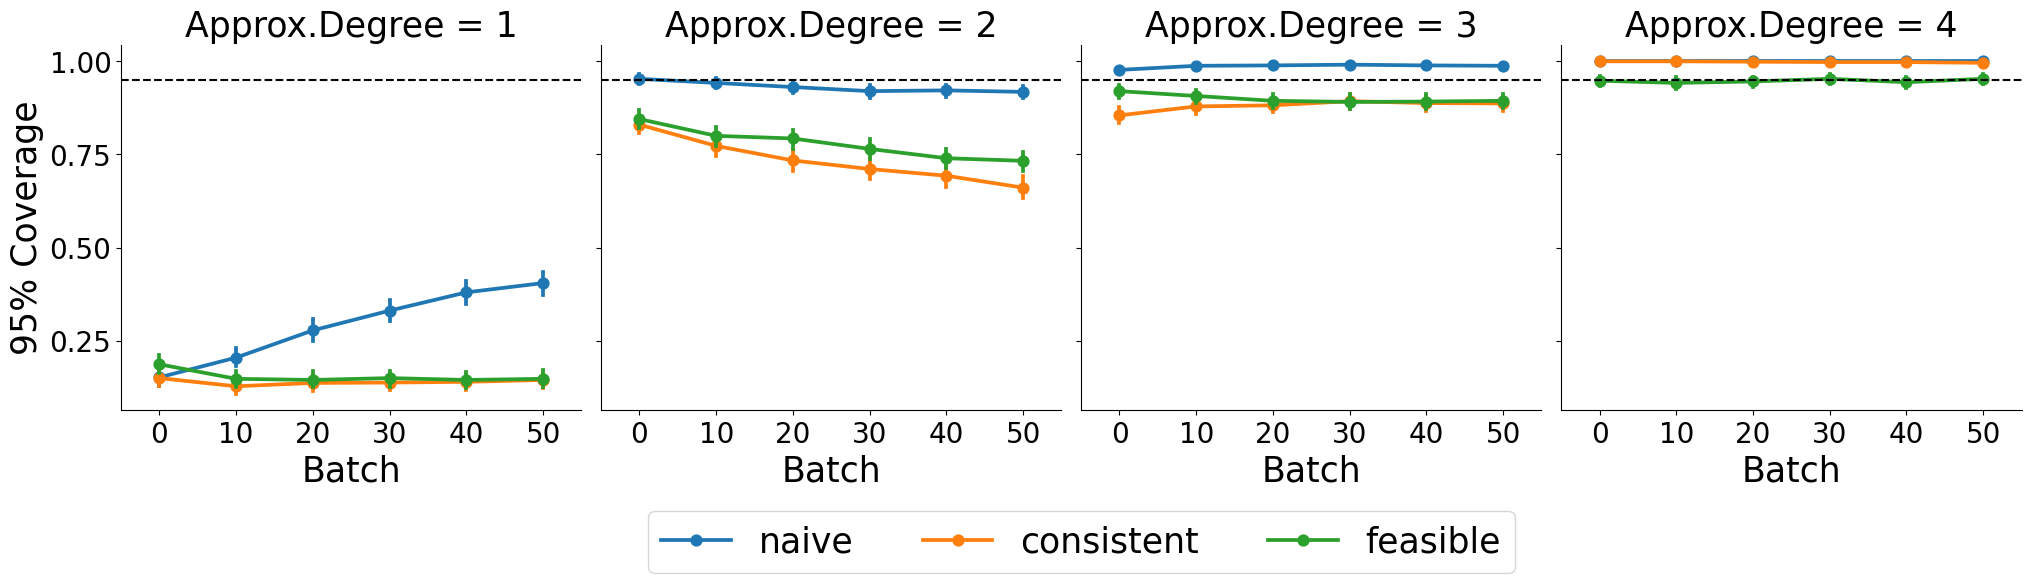

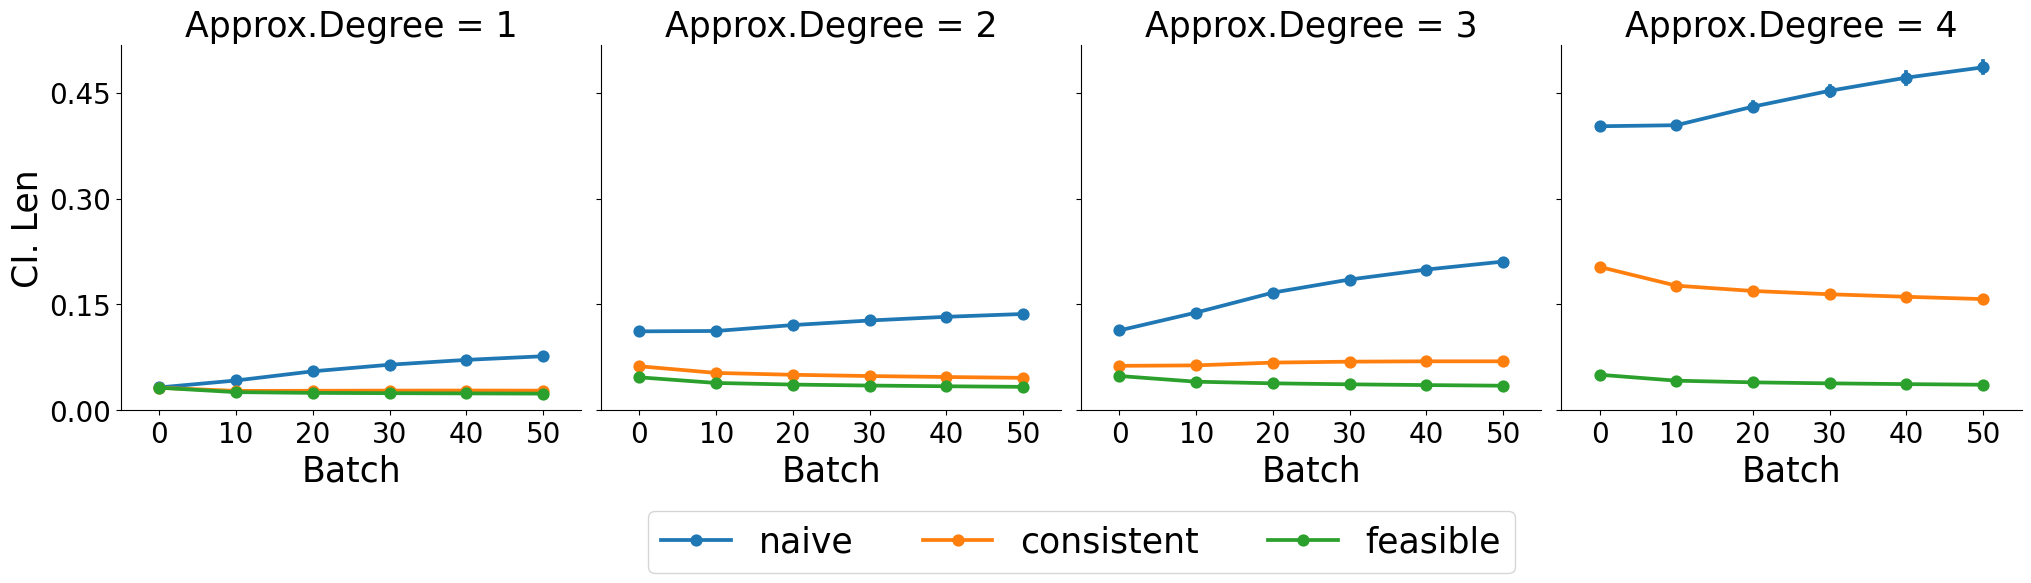

In [80]:
plot_misspec(df_params_misspec, 'cov_param', col='approx_degree', baselines=[confidence] * 4, col_wrap=4, yname=f'{int(confidence * 100)}% Coverage')
plt.savefig('./plots/misspec_cov_gmm.pdf', bbox_inches='tight')
plot_misspec(df_params_misspec, 'std',  col='approx_degree', estimator=lambda x:4*np.mean(x), col_wrap=4, yname='CI. Len')
plt.savefig('./plots/misspec_ci_gmm.pdf', bbox_inches='tight')

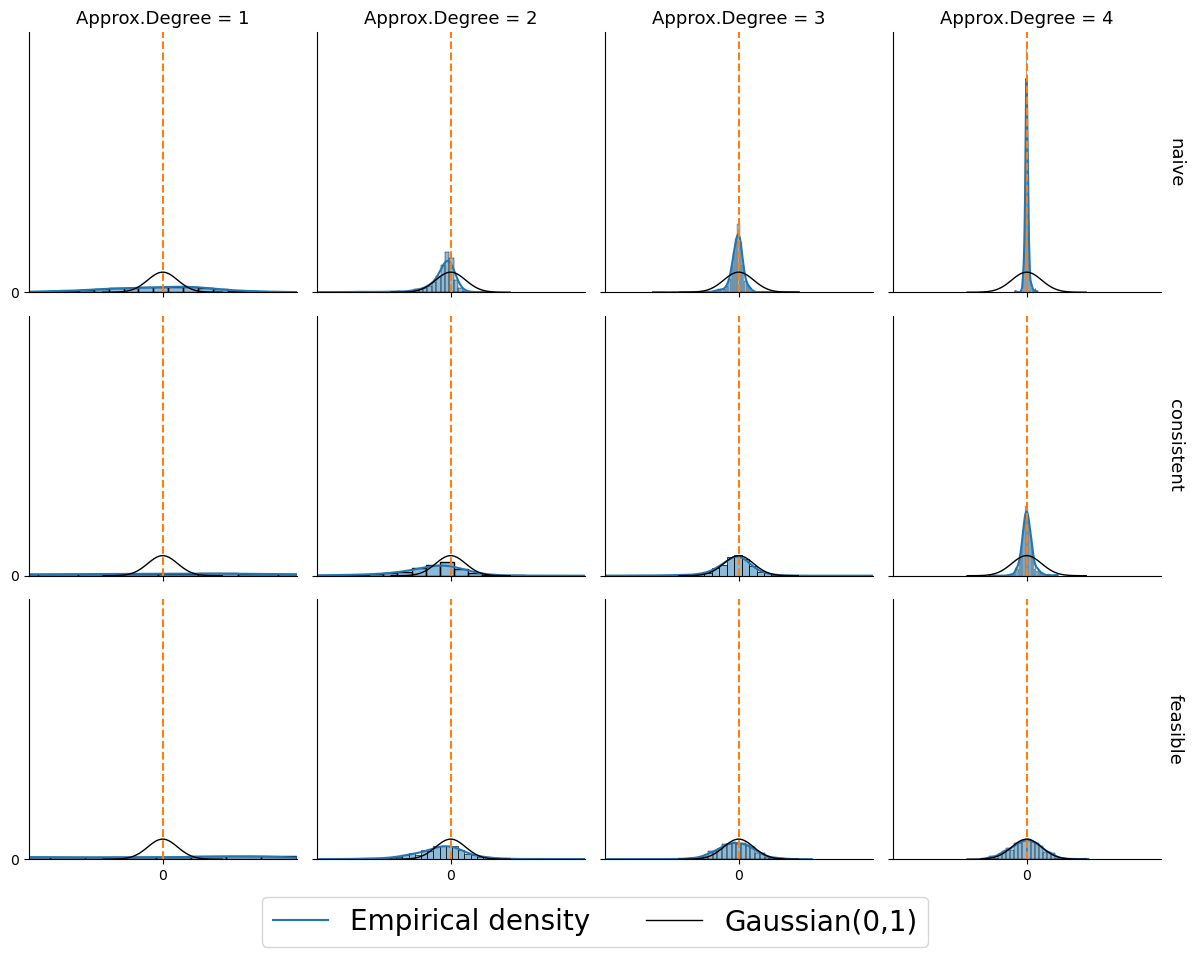

In [81]:
df = df_params_misspec.query("batch==50")
g = sns.FacetGrid(row="weights",
                  sharex=True,
                  sharey=True,
                  col='approx_degree',
                  #ylim=(0, .8),
                  xlim=(-9, 9),
                  #margin_titles=True,
                  data=df,
                  margin_titles=True)
g = g.map(sns.histplot, 'tstat_param', kde=True, stat="density")
xs = np.linspace(-4, 4)
means = [df.query("weights=='naive'")['tstat_param'].mean()]
for ax in  g.axes.flatten():
    ax.plot(xs, norm.pdf(xs),label='N(0,1)', **{"color":"black", "linestyle":"-", "linewidth":1})
    ax.set(xlabel="")
    ax.set(ylabel="")
    ax.axvline(x=0, color="tab:orange", ls="--")
    ax.set_xticks([0])
    ax.set_yticks([0])
handles, labels = g._legend_data.values(), g._legend_data.keys()
g.fig.legend(labels=['Empirical density', 'Gaussian(0,1)'],  loc="lower center", ncol=2, 
                 bbox_to_anchor=(0.5, -0.07),  fontsize=20)
g.fig.tight_layout()
g.set_titles(col_template='Approx.Degree = {col_name}', row_template='{row_name}', size=13)
plt.savefig('./plots/misspec_hist_gmm.pdf', bbox_inches='tight')

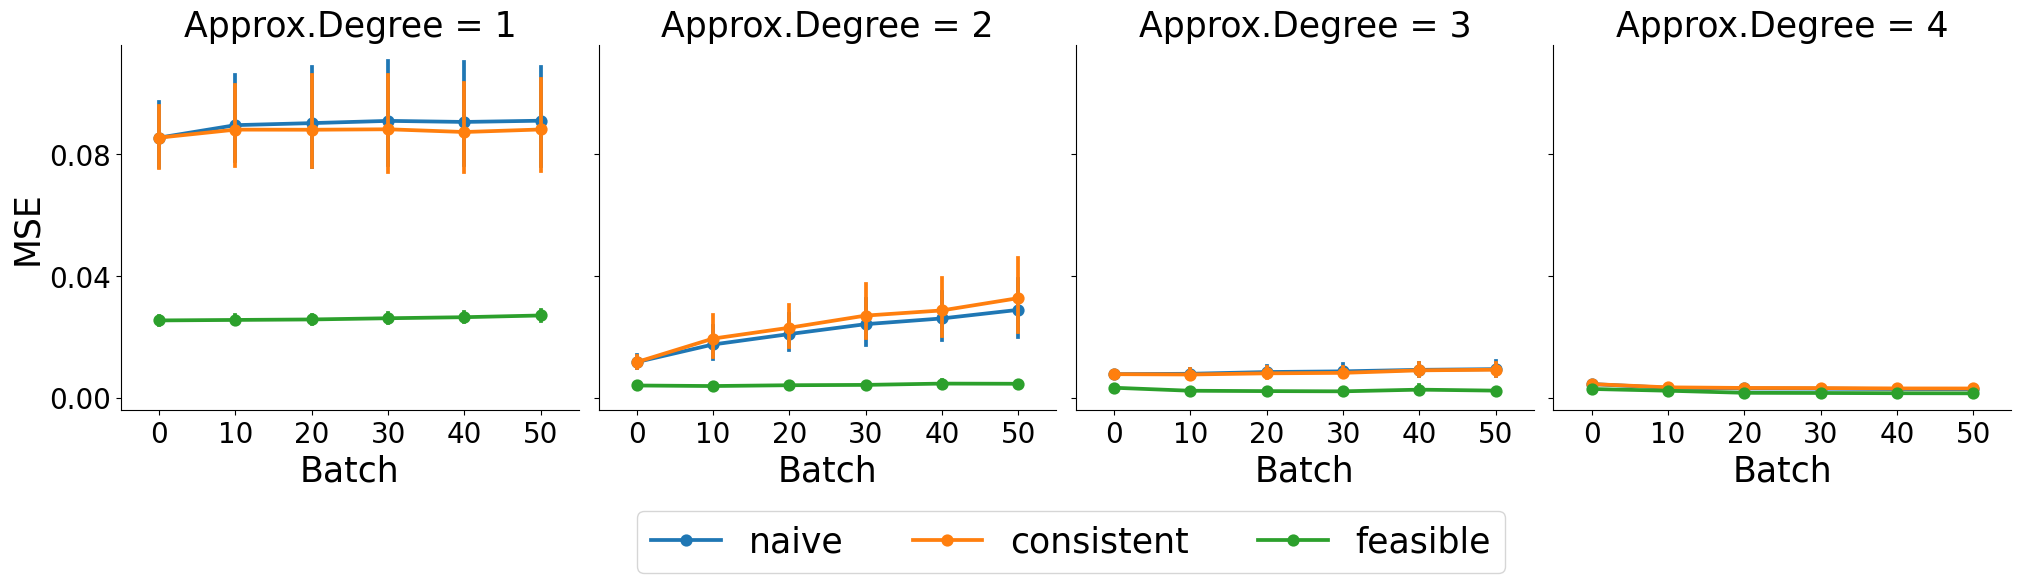

In [82]:
plot_misspec(df_params_misspec, 'mse', yname='MSE',col_wrap=4)
plt.savefig('./plots/misspec_mse_gmm.pdf', bbox_inches='tight')

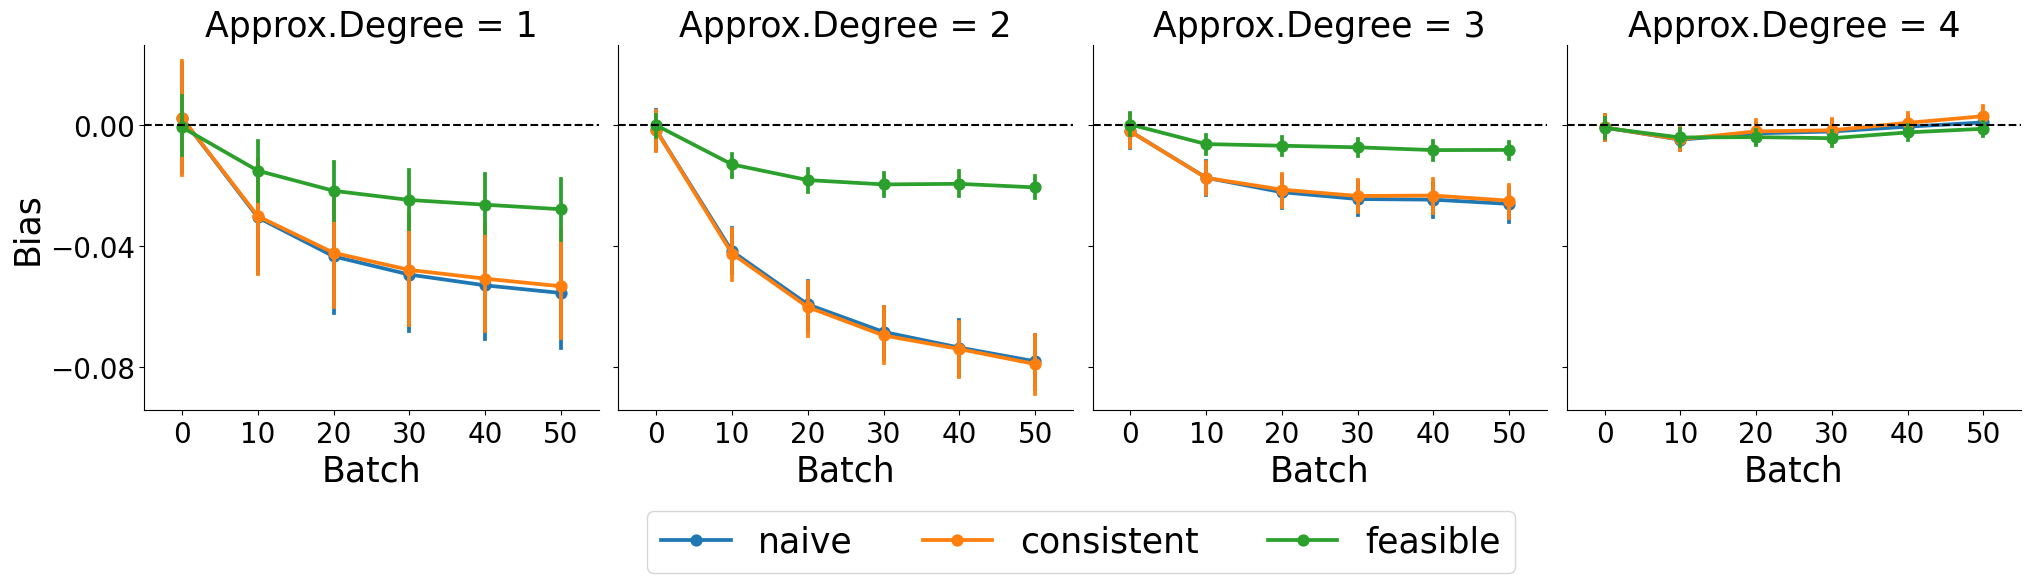

In [83]:
plot_misspec(df_params_misspec, 'error', baselines=[0]*4, col_wrap=4, yname='Bias')
plt.savefig('./plots/misspec_bias_gmm.pdf', bbox_inches='tight')

In [180]:
df_params.to_csv('./plots/df_params.csv')

In [181]:
df_params_misspec.to_csv('./plots/df_params_misspec.csv')